# PGM Exercise - Preprocessing the training data

### Setup
Uncomment and run the below block for the first time, to install the required packages

In [ ]:
#!conda install -c conda-forge scikit-learn -y
#!conda install spacy -y
#!conda install tqdm -y
#!conda install pandas -y
#!python -m spacy download en_core_web_sm

In [1]:
from sklearn.datasets import fetch_20newsgroups
import spacy
import tqdm
from collections import Counter
import pandas as pd
import re

In [2]:
data = fetch_20newsgroups(subset="train", remove=('headers', 'footers', 'quotes'))
nlp = spacy.load("en_core_web_sm")

print('Number of docs:', len(data.data))

Number of docs: 11314


## Convert docs to list of tokens

In [3]:
unprocessed_docs = data['data']
def pre_process_docs_before_vocab(unprocessed_docs):
    docs = []
    patterns_and_replacements = {
        '<EMAIL>' : re.compile(r'^[\w\.-]+@[\w\.-]+\.\w+$')
    }

    for udoc in tqdm.tqdm_notebook(nlp.pipe(unprocessed_docs, batch_size=64), total=len(unprocessed_docs)):
        doc = []
        for token in udoc:
            if token.is_alpha:
                doc.append(token.text.lower())
            elif token.is_punct:
                # since punctuation would be one of the syntactic classes
                doc.append(token.text[0]) # why just text[0]? to handle cases like '!!!' or '...'
            elif token.is_space:
                # all space char including '\n' provides no meaning
                continue
            elif token.is_digit:
                doc.append('<NUM>')
            elif token.is_currency:
                doc.append('<CUR>')
            else:
                for replacement, pattern in patterns_and_replacements.items():
                    if pattern.match(token.text):
                        doc.append(replacement)
                        break

        docs.append(doc)
    return docs

docs = pre_process_docs_before_vocab(unprocessed_docs)

C:\Users\latip\AppData\Local\Temp\ipykernel_9268\2012577019.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for udoc in tqdm.tqdm_notebook(nlp.pipe(unprocessed_docs, batch_size=64), total=len(unprocessed_docs)):


  0%|          | 0/11314 [00:00<?, ?it/s]

## Build vocabulary

We will also remove the words that occur only once, since there is a good chance that those are typos

In [4]:
def build_vocab(docs, rare_words_threshold):
    vocab = Counter()
    for doc in tqdm.tqdm_notebook(docs):
        vocab.update(doc)

    # ignore words that are rare
    vocab = Counter({key: count for key, count in vocab.items() if count > rare_words_threshold})
    return vocab

vocab = build_vocab(docs, rare_words_threshold=1)

C:\Users\latip\AppData\Local\Temp\ipykernel_9268\397447190.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for doc in tqdm.tqdm_notebook(docs):


  0%|          | 0/11314 [00:00<?, ?it/s]

In [5]:
def remove_out_of_vocab_tokens(docs, vocab):
    oov_count = 0
    for doc in docs:
        for ind, token in enumerate(doc):
            if token not in vocab:
                del doc[ind]
                oov_count += 1
    return docs, vocab


docs, vocab = remove_out_of_vocab_tokens(docs, vocab)

## View the processed data

In [6]:
def compare_text_after_pre_processing(index, orig_docs, pre_processed_docs):
    print("------- Original -------")
    print(orig_docs[index])
    print("\n\n\n------- After preprocessing -------")
    print(' '.join(pre_processed_docs[index]))

print("Vocab size: ", len(vocab))
print("\n\nExample after preprocessing")
compare_text_after_pre_processing(index=0, orig_docs=data['data'], pre_processed_docs=docs)





most_common = vocab.most_common()[:30]
least_common = vocab.most_common()[-30:]

print("\n\n\n------- MOST COMMON ITEMS IN VOCAB -------")
print(pd.DataFrame(most_common, columns=['Word', 'Count']))


print("\n\n\n------- Least COMMON ITEMS IN VOCAB -------")
print(pd.DataFrame(least_common[::-1], columns=['Word', 'Count']))

Vocab size:  33298


Example after preprocessing
------- Original -------
I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.



------- After preprocessing -------
i was wondering if anyone out there could enlighten me on this car i saw the other day . it was a <NUM> - door sports car , looked to be from the late early . it was called a bricklin . the doors were really small . in addition , the front bumper was separate from the rest of the body . this is all i know . if anyone can a model name , engine specs , years of production , where this car is made , history , o

In [7]:
processed_docs = []
words = list(vocab.keys())
for doc in docs:
  doc_words = []
  for word in doc:
    if word in words:
      word_idx = words.index(word)
      doc_words.append(word_idx)
  processed_docs.append(doc_words)




In [8]:
import numpy as np

M = len(docs)
N = len(vocab)
T = 10
C = 5

alpha = 0.1
beta = 0.01
delta = 0.1
gamma = 0.1

theta_d_z = np.zeros((M, T))
phi_z_w = np.zeros((T, N))
phi_c_w = np.zeros((C, N))
transition_matrix = np.zeros((C, C))
z_d_i = [np.random.randint(0, T, size=len(doc)) for doc in processed_docs]
c_d_i = [np.random.randint(0, C, size=len(doc)) for doc in processed_docs]
# z_d_i = [[0 for _ in range(len(doc))] for doc in docs]
# c_d_i = [[0 for _ in range(len(doc))] for doc in docs]

n_d = np.zeros((M))
n_z = np.zeros((T))
n_c = np.zeros((C))

In [9]:
for d, doc in enumerate(processed_docs):
  previous_class = None
  for i, word in enumerate(doc):
    c = c_d_i[d][i]
    if c == 0:
      z = z_d_i[d][i]
      theta_d_z[d][z] += 1
      phi_z_w[z, word] += 1
      n_z[z] += 1
    phi_c_w[c, word] += 1
    n_c[c] += 1

    n_d[d] += 1
    if previous_class is not None:
      transition_matrix[previous_class, c] += 1
    previous_class = c


In [ ]:
def print_n_c():
  print(n_c)

print_n_c()



[527020. 526507. 526686. 526684. 528482.]


In [ ]:
print(c_d_i[0])

[4 4 4 3 2 2 3 0 1 3 0 0 0 2 2 4 1 0 0 2 3 1 1 3 0 0 1 2 3 3 3 1 1 0 0 1 1
 4 3 0 4 4 4 4 0 2 1 1 3 1 3 2 0 2 3 0 2 4 1 4 3 4 4 4 0 4 3 4 4 2 0 4 2 2
 0 3 0 0 2 3 2 3 3 0 0 4 2 4 1 4 1 4 4 2 2 3 4 3 1 4 2 3 4 3 1 3 4]


In [10]:
def draw_topic(d, i, word):
  z = z_d_i[d][i]
  c = c_d_i[d][i]

  if c == 0: # if the class is semantic class
    theta_d_z[d][z] -= 1
    phi_z_w[z, word] -= 1
    n_z[z] -= 1

  p_t_minus = theta_d_z[d] + alpha
  p_w_z = 1.0

  if c == 0:
    p_w_z = (phi_z_w[:, word] + beta) / (n_z + N * beta)

  p_z = p_t_minus * p_w_z

  p_z = p_z / np.sum(p_z)


  # new_z = np.random.multinomial(1, p_z).argmax()
  new_z = np.random.choice(np.arange(T), p=p_z)
  z_d_i[d][i] = new_z


  if c == 0:
    theta_d_z[d][new_z] += 1
    phi_z_w[new_z, word] += 1
    n_z[new_z] += 1






In [11]:
def draw_class(d, i, word, doc_size):
    z = z_d_i[d][i]
    c = c_d_i[d][i]

    phi_c_w[c, word] -= 1
    n_c[c] -= 1

    p_w_c = (phi_c_w[:, word] + delta) / (n_c + N * delta)
    p_w_c[0] = (phi_z_w[z, word] + beta) / (n_z[z] + N * beta)

    previous = None if i == 0 else c_d_i[d][i - 1]
    next = None if i == (doc_size - 1) else  c_d_i[d][i + 1]

    if previous is not None:
      transition_matrix[previous][c] -= 1

    if next is not None:
      transition_matrix[c][next] -= 1

    n_c_minus = np.zeros(C) if previous is None else transition_matrix[previous, :]
    n_c_plus = np.zeros(C) if next is None else transition_matrix[:, next]

    i_c_minus_plus = np.zeros(C)
    i_c_minus = np.zeros(C)

    if previous == c and c == next:
      i_c_minus_plus[c] = 1

    if previous == c:
      i_c_minus[c] == 1


    p_c_minus = (n_c_minus + gamma) * (n_c_plus + i_c_minus_plus + gamma) / (n_c + i_c_minus + C * gamma)

    p_c = p_w_c * p_c_minus

    p_c = p_c / np.sum(p_c)

    try:
      new_c = np.random.choice(np.arange(C), p=p_c)
    except Exception as e:
      print(f"p_c: {p_c}\n")
      print(f"p_w_c: {p_w_c}\n")
      print(f"p_c_minus: {p_c_minus}")
      print(f"n_c: {n_c}")
      print(f"n_c_minus: {n_c_minus}")
      print(f"n_c_plus: {n_c_plus}")
      raise e

    c_d_i[d][i] = new_c

    phi_c_w[new_c, word] += 1
    n_c[new_c] += 1

    if previous is not None:
      transition_matrix[previous][new_c] += 1

    if next is not None:
      transition_matrix[new_c][next] += 1

    if new_c == 0:
      theta_d_z[d][z] += 1
      phi_z_w[z, word] += 1
      n_z[z] += 1




In [ ]:
from tqdm.notebook import tqdm


iterations_num = 100

for iteration in tqdm(range(iterations_num)):
  for d, doc in enumerate(processed_docs):
    for i, word in enumerate(doc):
      draw_class(d, i, word, len(doc))
      draw_topic(d, i, word)





  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
p = [ 1.00386207e+00, -3.86206700e-03, -6.49425105e-11, -1.15244206e-11,
 -6.56902187e-17]


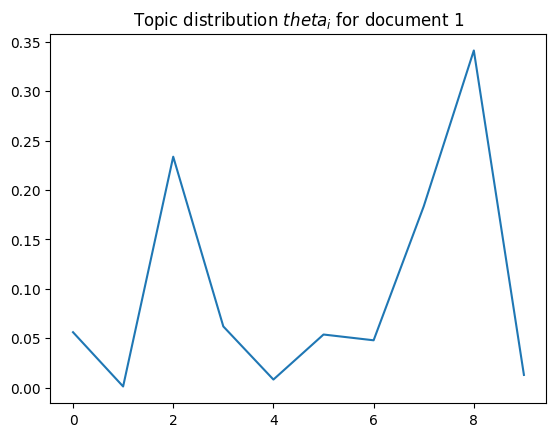

In [ ]:
import matplotlib.pyplot as plt

i = 1
plt.plot(theta_d_z[i]/ sum(theta_d_z[i]));
plt.title("Topic distribution $theta_i$ for document {}".format(i));

In [ ]:
n_top_words = 10
for topic_idx, topic in enumerate(phi_z_w):
    message = "Topic #%d: " % topic_idx
    message += " ".join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
    print(message)

Topic #0: <UNK> . the , <NUM> to of a and -
Topic #1: <UNK> . , the to <NUM> of and a -
Topic #2: <UNK> , . the <NUM> to of a - and
Topic #3: <UNK> . , the <NUM> to of a and -
Topic #4: <UNK> . , the <NUM> to of and a -
Topic #5: <UNK> the . , <NUM> to of and - a
Topic #6: <UNK> the . , to <NUM> of a and -
Topic #7: <UNK> . the , of <NUM> to a and -
Topic #8: <UNK> , . the <NUM> to of a and -
Topic #9: <UNK> the . , <NUM> to of and a -
